In [21]:
import numpy as np 
import pandas as pd 
import multiprocessing as multi
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import time
from astropy.cosmology import Planck18 as cosmo

In [2]:
%%capture PC_name 
!hostname

**Setting notebook parameters**

In [3]:
#setting dots per inch for images
dpi = 90

#setting number of processors for multiprocessing
PC_name_str = PC_name.stdout[0:-2]

if (PC_name_str == 'arc10'or PC_name_str == 'science11' or 
        PC_name_str == 'science10'):
    cores = 42        
#     cores = multi.cpu_count()
    
else:
    cores = multi.cpu_count()

print(PC_name_str)
print(cores)

arc10
42


In [52]:
df_sdss_gals = pd.read_csv('../codes_for_SDSS/Data/SAS_FITS/galaxy_DR12v5_CMASSLOWZTOT_all_sky_Comov.csv',
                         index_col = 0)
df_sdss_gals.describe().apply(lambda s: s.apply('{0:.3f}'.format))

,RA,DEC,Z,r_comov[Mpc/h],X_comov[Mpc/h],Y_comov[Mpc/h],Z_comov[Mpc/h]
count,1325735.000,1325735.000,1325735.000,1325735.000,1325735.000,1325735.000,1325735.000
mean,178.676,23.417,0.452,2596.975,-594.580,-74.705,976.706
std,92.194,18.180,0.157,823.919,1964.434,1263.945,808.397
min,0.000,-10.997,0.000,0.032,-4993.670,-4315.740,-805.466
25%,135.845,8.361,0.347,2083.786,-2049.560,-983.879,307.587
50%,181.891,21.477,0.486,2808.285,-1230.263,-33.060,847.189
75%,227.366,35.940,0.563,3185.174,1177.849,835.904,1535.834
max,359.999,68.738,1.137,5500.920,4902.803,4241.546,4441.835


In [56]:
df_sdss_gals['X_comov[kpc/h]'] = df_sdss_gals['X_comov[Mpc/h]']*1e3
df_sdss_gals['Y_comov[kpc/h]'] = df_sdss_gals['Y_comov[Mpc/h]']*1e3
df_sdss_gals['Z_comov[kpc/h]'] = df_sdss_gals['Z_comov[Mpc/h]']*1e3
df_sdss_gals.head()

,RA,DEC,Z,r_comov[Mpc/h],X_comov[Mpc/h],Y_comov[Mpc/h],Z_comov[Mpc/h],x_comov[kpc/h],X_comov[kpc/h],Y_comov[kpc/h],Z_comov[kpc/h]
0,195.071285,-0.590771,0.465648,2704.395477,-2611.233755,-703.161177,-27.884270,-2.611234e+06,-2.611234e+06,-703161.177447,-27884.269664
1,195.022992,-0.610999,0.565802,3197.099944,-3087.653536,-828.662392,-34.093028,-3.087654e+06,-3.087654e+06,-828662.392027,-34093.027531
2,195.079741,0.348981,0.612211,3415.450663,-3297.777358,-888.557803,20.802909,-3.297777e+06,-3.297777e+06,-888557.802646,20802.909209
3,195.170574,0.359864,0.502060,2886.985908,-2786.322445,-755.490623,18.132505,-2.786322e+06,-2.786322e+06,-755490.623176,18132.505089
4,195.204289,0.347267,0.559173,3165.404974,-3054.549769,-830.148348,19.185261,-3.054550e+06,-3.054550e+06,-830148.348049,19185.260862


In [5]:
df_act_clus = pd.read_csv('Data/ACT_DR5_Clusters_Comov.csv', index_col = 0)
df_act_clus.describe()

,RADeg,decDeg,redshift,M500,r_comov[Mpc/h],x_comov[Mpc/h],y_comov[Mpc/h],z_comov[Mpc/h]
count,4195.000000,4195.000000,4195.000000,4195.000000,4195.000000,4195.000000,4195.000000,4195.000000
mean,151.193567,-11.682177,0.550965,2.621147,3030.791002,471.456800,324.588298,-565.562838
std,117.664528,24.306970,0.260175,1.092935,1210.984726,2364.292580,1635.569100,1319.756732
min,0.020896,-59.987040,0.035200,1.042072,228.608662,-6163.229233,-5208.507048,-5650.519796
25%,39.386235,-34.828811,0.354170,1.961358,2120.021116,-1613.598656,-775.581220,-1455.432920
50%,144.342767,-2.252158,0.519816,2.361268,2974.576250,1069.530532,384.114036,-99.930771
75%,232.604297,8.957936,0.709455,2.937229,3853.453854,2242.835822,1467.460902,367.275769
max,359.988280,20.486048,1.910000,13.442958,7645.791379,6535.053581,5109.411777,2019.742158


In [57]:
df_act_clus['x_comov[kpc/h]'] = df_act_clus['x_comov[Mpc/h]']*1e3
df_act_clus['y_comov[kpc/h]'] = df_act_clus['y_comov[Mpc/h]']*1e3
df_act_clus['z_comov[kpc/h]'] = df_act_clus['z_comov[Mpc/h]']*1e3
df_act_clus.head()

,RADeg,decDeg,redshift,M500,r_comov[Mpc/h],x_comov[Mpc/h],y_comov[Mpc/h],z_comov[Mpc/h],x_comov[kpc/h],y_comov[kpc/h],z_comov[kpc/h]
0,0.020896,-38.626729,0.300599,1.683921,1825.260116,1425.946665,0.520058,-1139.407886,1.425947e+06,520.057670,-1.139408e+06
1,0.061318,-43.955645,0.878131,2.437253,4554.508919,3278.685902,3.508881,-3161.290549,3.278686e+06,3508.880938,-3.161291e+06
2,0.089905,-28.091255,0.282570,2.700574,1723.993853,1520.903339,2.386502,-811.789470,1.520903e+06,2386.502199,-8.117895e+05
3,0.113536,-1.044805,0.438800,1.493793,2567.184731,2566.752876,5.086245,-46.810749,2.566753e+06,5086.245373,-4.681075e+04
4,0.113978,-5.880626,0.201735,1.623578,1257.042246,1250.424611,2.487471,-128.791742,1.250425e+06,2487.470881,-1.287917e+05


In [63]:
def pre_fac_func(z):
    
    f = cosmo.Om0**0.545
    a = 1/(1+z)
    H = cosmo.H(z).value
    
    pre_fac = (f * a * H / (4 * np.pi))           #in km s^−1 Mpc^−1 
    
    return pre_fac

In [64]:
pre_fac_func(z)

2.5147943204092167

In [58]:
def gehrels_confidence_limits(gals_in_cell):
    
    #Using Eq. 9 of Gehrels(1985)
    S = 1 #determining 1 sigma error bars
    gals_in_cell_up = (gals_in_cell + 1) * (1 - (1 /(9 * (gals_in_cell + 1))) + (S / (3 * np.sqrt(gals_in_cell + 1))))**3
    
    gals_in_cell_copy = gals_in_cell.copy() #To avoid division by zero error
    gals_in_cell_copy[gals_in_cell == 0] = 1.5
    
    #using Eq. 14 of Gehrels(1985)
    gals_in_cell_low = gals_in_cell_copy * (1 - (1 / (9 * gals_in_cell_copy)) - (S / (3 * np.sqrt(gals_in_cell_copy))))**3 #beta is 0 for S = 1
    
    gals_in_cell_low[gals_in_cell == 0] = 0
    
    gals_in_cell_up_err = gals_in_cell_up - gals_in_cell
    gals_in_cell_low_err = gals_in_cell - gals_in_cell_low
    
    return gals_in_cell_up_err, gals_in_cell_low_err

In [59]:
def delta_gal_mean_func(df_act_clus_available, cell_size, radius):
    
    delta_gal_cube = np.zeros(len(df_act_clus_available))
    
    for i, clus in df_act_clus_available.iterrows():
        df_gals_around = df_sdss_gals[(df_sdss_gals['X_comov[kpc/h]'] < (clus['x_comov[kpc/h]'] + radius)) &
                                      (df_sdss_gals['X_comov[kpc/h]'] > (clus['x_comov[kpc/h]'] - radius)) &
                                      (df_sdss_gals['Y_comov[kpc/h]'] < (clus['y_comov[kpc/h]'] + radius)) &
                                      (df_sdss_gals['Y_comov[kpc/h]'] > (clus['y_comov[kpc/h]'] - radius)) &
                                      (df_sdss_gals['Z_comov[kpc/h]'] < (clus['z_comov[kpc/h]'] + radius)) &
                                      (df_sdss_gals['Z_comov[kpc/h]'] > (clus['z_comov[kpc/h]'] - radius))].copy()
        
        
        #moving the galxies cube to lie within 0 to 240,000 h^-1 kpc 
        df_gals_around['X_comov[kpc/h]'] -= (clus['x_comov[kpc/h]'] - radius)
        df_gals_around['Y_comov[kpc/h]'] -= (clus['y_comov[kpc/h]'] - radius)
        df_gals_around['Z_comov[kpc/h]'] -= (clus['z_comov[kpc/h]'] - radius)

        df_gals_around['X_comov[kpc/h]'] = df_gals_around['X_comov[kpc/h]'] / cell_size
        df_gals_around['Y_comov[kpc/h]'] = df_gals_around['Y_comov[kpc/h]'] / cell_size
        df_gals_around['Z_comov[kpc/h]'] = df_gals_around['Z_comov[kpc/h]'] / cell_size

        #making tuples, converting tuples to cell coordinates
        df_gals_around["cell"] = list(zip(df_gals_around['X_comov[kpc/h]'].astype(int), 
                                          df_gals_around['Y_comov[kpc/h]'].astype(int), 
                                          df_gals_around['Z_comov[kpc/h]'].astype(int)))
        
        diameter = radius * 2
        #array to store number of galaxies in the cells
        gals_in_cell = np.zeros((diameter//cell_size, diameter//cell_size, diameter//cell_size))

        #counting number of galaxies in the cells
        for cell in df_gals_around["cell"]:
            x, y, z = cell
    
            try:
                gals_in_cell[x, y, z] += 1

            except:
                print('\n')
                print(i)
                print(gals_in_cell.shape)
                print(x, y, z)
                print(df_act_clus_available.loc[[i]])
                raise SystemExit

        delta_gal_cube[i] = np.mean(gals_in_cell)
    
    return np.mean(delta_gal_cube)

In [86]:
def overdensity_field_calc(clus_x, clus_y, clus_z, cell_size, clus_cube_size):

    #converting strings into floats
    clus_x = float(clus_x); clus_y = float(clus_y); clus_z = float(clus_z)
    
    #filtering galaxies in a cube of 240,000 h^-1 kpc around the given cluster
    df_gal_select = df_sdss_gals[(df_sdss_gals['X_comov[kpc/h]'] > (clus_x - clus_cube_size//2)) & 
                                 (df_sdss_gals['X_comov[kpc/h]'] < (clus_x + clus_cube_size//2)) & 
                                 (df_sdss_gals['Y_comov[kpc/h]'] > (clus_y - clus_cube_size//2)) & 
                                 (df_sdss_gals['Y_comov[kpc/h]'] < (clus_y + clus_cube_size//2)) & 
                                 (df_sdss_gals['Z_comov[kpc/h]'] > (clus_z - clus_cube_size//2)) & 
                                 (df_sdss_gals['Z_comov[kpc/h]'] < (clus_z + clus_cube_size//2))]
        
    #making copy to extract coordinates of cells containing the galaxies
    df_gal_cube = df_gal_select.copy()
    
    #moving the galxies cube to lie within 0 to 240,000 h^-1 kpc 
    df_gal_cube['X_comov[kpc/h]'] -= (clus_x - (clus_cube_size//2))
    df_gal_cube['Y_comov[kpc/h]'] -= (clus_y - (clus_cube_size//2))
    df_gal_cube['Z_comov[kpc/h]'] -= (clus_z - (clus_cube_size//2))

    #dividing by 5000 (integer-div) so we get cell coordinates
    df_gal_cube['X_comov[kpc/h]'] = df_gal_cube['X_comov[kpc/h]'] // cell_size
    df_gal_cube['Y_comov[kpc/h]'] = df_gal_cube['Y_comov[kpc/h]'] // cell_size
    df_gal_cube['Z_comov[kpc/h]'] = df_gal_cube['Z_comov[kpc/h]'] // cell_size
    
    #making tuples, converting tuples to cell coordinates
    df_gal_cube["cell"] = list(zip(df_gal_cube['X_comov[kpc/h]'].astype(int), 
                                   df_gal_cube['Y_comov[kpc/h]'].astype(int), 
                                   df_gal_cube['Z_comov[kpc/h]'].astype(int)))
    
    #array to store number of galaxies in the cells
    gals_in_cell = np.zeros((clus_cube_size//cell_size, 
                             clus_cube_size//cell_size, 
                             clus_cube_size//cell_size))
    
    #counting number of galaxies in the cells
    for i, cell in enumerate(df_gal_cube["cell"]):
        x, y, z = cell
        
        try:
            gals_in_cell[x, y, z] += 1
            
        except:
            print('\n')
            print(i)
            print(clus_cube_size)
            print(cell_size)
            print(clus_cube_size//cell_size)
            print(gals_in_cell.shape)
            print(x, y, z)
            print(clus_x, clus_y, clus_z)
            print(df_gal_select.loc[[i]])
            raise SystemExit
            
            
            
        
    gals_in_cell_up_err, gals_in_cell_low_err = gehrels_confidence_limits(gals_in_cell)
    gals_in_cell_avg_err = (gals_in_cell_low_err + gals_in_cell_up_err) / 2 
    
    #calculating mean galaxy density
    rho_gal_mean = np.mean(gals_in_cell)
    
    #determining the overdensity of galaxies    
    delta_gal = (gals_in_cell/rho_gal_mean) - 1
    delta_gal_error = gals_in_cell_avg_err/rho_gal_mean  
    

    delta_gal_smooth = delta_gal.copy() #to avoid error calculation since 
    #smoothing not affecting velocities much (apparently, not at all with 2 Mpc)
        
    #obtaining matter overdensity from galaxies overdensity
    delta_matter = delta_gal_smooth / b
    delta_matter_error = delta_gal_error / b
    
    return delta_matter, delta_matter_error


**Calculating differential, numerator & denominator for Eq. 1**

In [61]:
def vel_terms_calc(cell_size, clus_cube_size):
    
    #calculating the differential in the Eq. 1
    dy_cubed = cell_size**3
    
    #specifing position of the clusters
    Rclus_x = np.zeros((clus_cube_size//cell_size, clus_cube_size//cell_size, clus_cube_size//cell_size))
    Rclus_x[:] = clus_cube_size//2
    Rclus_y = np.zeros((clus_cube_size//cell_size, clus_cube_size//cell_size, clus_cube_size//cell_size))
    Rclus_y[:] = clus_cube_size//2
    Rclus_z = np.zeros((clus_cube_size//cell_size, clus_cube_size//cell_size, clus_cube_size//cell_size))
    Rclus_z[:] = clus_cube_size//2

    #generating meshgrid containing coordinates of the centers of cells
    Rcell_x = np.zeros((clus_cube_size//cell_size, clus_cube_size//cell_size, clus_cube_size//cell_size))
    Rcell_y = np.zeros((clus_cube_size//cell_size, clus_cube_size//cell_size, clus_cube_size//cell_size))
    Rcell_z = np.zeros((clus_cube_size//cell_size, clus_cube_size//cell_size, clus_cube_size//cell_size))

    for i, val in enumerate(range(cell_size//2, clus_cube_size, cell_size)):
        Rcell_x[i,:,:] = val
        Rcell_y[:,i,:] = val
        Rcell_z[:,:,i] = val

    #evaluating the term in the denominator of Eq. 1 of Tanimura et al. 2020
    denom = np.sqrt((Rcell_x - Rclus_x)**2 + (Rcell_y - Rclus_y)**2 + (Rcell_z - Rclus_z)**2)**(3)

    #evaluating the direction term in the numerator of Eq. 1
    numer_x = Rcell_x - Rclus_x
    numer_y = Rcell_y - Rclus_y
    numer_z = Rcell_z - Rclus_z
    
    return (dy_cubed, numer_x, numer_y, numer_z, denom)


**Calculating velocity of clusters according to Eq. 1**

In [62]:
def clus_velocity_calc(clus_x, clus_y, clus_z, redshift, cell_size, vel_terms, 
                       clus_cube_size):
    
    delta_matter, delta_matter_error = overdensity_field_calc(clus_x, clus_y, clus_z, cell_size,  
                                          clus_cube_size)
    
    
    dy_cubed, numer_x, numer_y, numer_z, denom = vel_terms
    
    pre_fac = pre_fac_func(redshift)
       
    #estimating velocity in x direction
    integrand_x = dy_cubed * delta_matter * (numer_x/(cosmo.h*1e3)) / denom #in units of Mpc    
    integrand_x_error = dy_cubed * delta_matter_error * (numer_x/(cosmo.h*1e3)) / denom
    
    dist = np.cbrt(denom)
    integrand_x = integrand_x[dist < (clus_cube_size//2)]
    integrand_x_error = integrand_x_error[dist < (clus_cube_size//2)]
    
    vx_est = pre_fac * np.sum(integrand_x)
    vx_est_error = pre_fac * np.sqrt(np.sum(integrand_x_error**2))
    
        
    #estimating velocity in y direction
    integrand_y = dy_cubed * delta_matter * (numer_y/(cosmo.h*1e3)) / denom #in units of Mpc    
    integrand_y_error = dy_cubed * delta_matter_error * (numer_y/(cosmo.h*1e3)) / denom
    
       
    integrand_y = integrand_y[dist < (clus_cube_size//2)]
    integrand_y_error = integrand_y_error[dist < (clus_cube_size//2)]
    
    vy_est = pre_fac * np.sum(integrand_y)
    vy_est_error = pre_fac * np.sqrt(np.sum(integrand_y_error**2))
    
    
    #estimating velocity in z direction
    integrand_z = dy_cubed * delta_matter * (numer_z/(cosmo.h*1e3)) / denom #in units of Mpc   
    integrand_z_error = dy_cubed * delta_matter_error * (numer_z/(cosmo.h*1e3)) / denom
    
    integrand_z = integrand_z[dist < (clus_cube_size//2)]
    integrand_z_error = integrand_z_error[dist < (clus_cube_size//2)]
    
    vz_est = pre_fac * np.sum(integrand_z)
    vz_est_error = pre_fac * np.sqrt(np.sum(integrand_z_error**2))
    
    
    return(vx_est, vy_est, vz_est, vx_est_error, vy_est_error, vz_est_error)


In [84]:
def df_clus_available_func(radius):
    
    df_act_clus = pd.read_csv(f'Data/z_gt_4_lt_7/ACT_clus_available_{radius}.csv',
                                           index_col = 0)

    df_act_clus['x_comov[kpc/h]'] = df_act_clus['x_comov[Mpc/h]']*1e3
    df_act_clus['y_comov[kpc/h]'] = df_act_clus['y_comov[Mpc/h]']*1e3
    df_act_clus['z_comov[kpc/h]'] = df_act_clus['z_comov[Mpc/h]']*1e3
    
    return df_act_clus

In [88]:
def plotting_func(df_clusters_est_err, cell_size, clus_cube_size):
    
    plt.figure(dpi = dpi)
    
    plt.hist(df_clusters_est_err['v_los_est[km/s]'], bins = 100)
    plt.xlabel('V$_{\mathrm{los}}$ (km/s)')
    plt.ylabel('No of clusters')
    
    plt.title('Reconstructed velocity | ' + 
              f'Cell size: {int(cell_size/1e3)} Mpc/h')
    
    plt.tight_layout()
    plt.savefig(f'Plots/z_gt_4_lt_7/vel_hist_{cell_size}.jpg', dpi = dpi)
    
    
    plt.figure(dpi = dpi)
    
    plt.hist(df_clusters_est_err['v_los_est_err[km/s]'], bins = 100)
    plt.xlabel('Error in V$_{\mathrm{los}}$ (km/s)')
    plt.ylabel('No of clusters')
    
    plt.title('Errors in reconstructed velocity | ' + 
              f'Cell size: {int(cell_size/1e3)} Mpc/h')
    
    plt.tight_layout()
    plt.savefig(f'Plots/z_gt_4_lt_7/error_hist_{cell_size}.jpg', dpi = dpi)
    

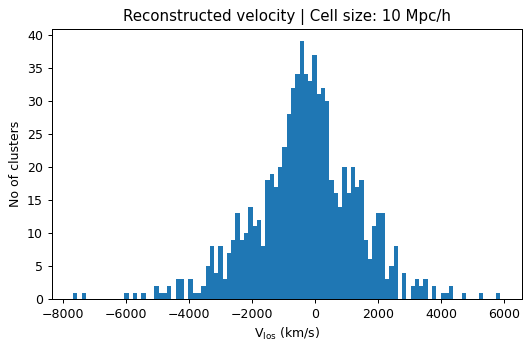

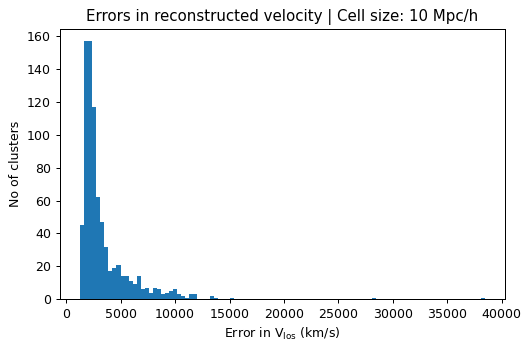

In [89]:
plotting_func(df_clusters_est_err, cell_size, clus_cube_size)

5000 500000
Time taken: 37.788023233413696


10000 500000
Time taken: 7.08573579788208


CPU times: user 12 s, sys: 23.1 s, total: 35.1 s
Wall time: 44.9 s


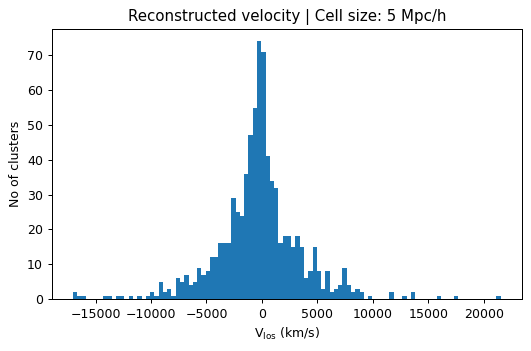

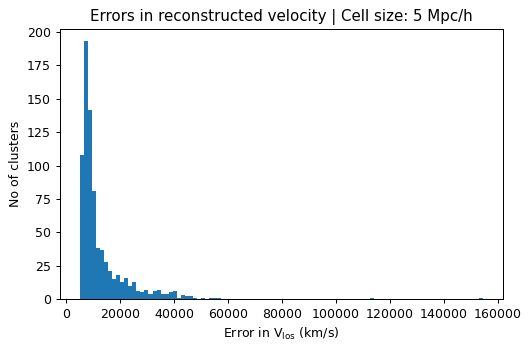

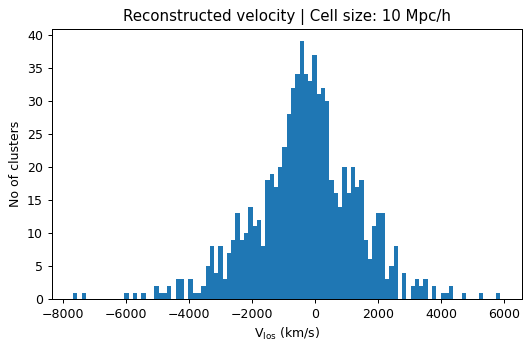

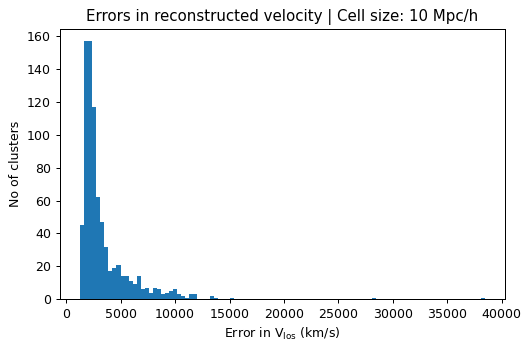

In [90]:
%%time
cores = 64
b = 2                                #bias for LOWZ & CMASS galaxies as taken by Tanimura et al. 2020

clus_mass_bins_results = pd.DataFrame(columns=['Cell Size',
                                'Cube Size', 'Clusters', 
                                'Slope - Vlos', 'Error - Slope - Vlos', 
                                'Intercept - Vlos', 'Scatter - Vlos'])


# clus_cube_sizes = [400000, 500000, 60000]
for clus_cube_size in [500000]:
    for cell_size in [5000, 10000]:                       #kpc/h, size of pixel or cell
#     for cell_size in [10000]: 
        
        t = time.time()                 
        print(cell_size, clus_cube_size)
        
        radius = int(clus_cube_size//2e3)        
        df_act_clus_available = df_clus_available_func(radius)
                
               
        vel_terms = vel_terms_calc(cell_size, clus_cube_size)        
        no_of_clus = len(df_act_clus_available)

        clus_param = list(zip(df_act_clus_available['x_comov[kpc/h]'], 
                                df_act_clus_available['y_comov[kpc/h]'], 
                                df_act_clus_available['z_comov[kpc/h]'], 
                                df_act_clus_available['redshift'], 
                                [cell_size] * no_of_clus,
                                [vel_terms]  * no_of_clus, 
                                [clus_cube_size] * no_of_clus
                               ))
        pool = multi.Pool(processes = cores)
        v_est = pool.starmap(clus_velocity_calc, clus_param)

        
        df_clusters_est_err = df_act_clus_available.copy()    

        df_clusters_est_err['vx_est[km/s]'] = [i[0] for i in v_est]
        df_clusters_est_err['vy_est[km/s]'] = [i[1] for i in v_est]
        df_clusters_est_err['vz_est[km/s]'] = [i[2] for i in v_est]

        df_clusters_est_err['vx_est_err[km/s]'] = [i[3] for i in v_est]
        df_clusters_est_err['vy_est_err[km/s]'] = [i[4] for i in v_est]
        df_clusters_est_err['vz_est_err[km/s]'] = [i[5] for i in v_est]
        
        df_clusters_est_err['r_mag[kpc/h]'] = np.sqrt(df_clusters_est_err['x_comov[kpc/h]']**2 +
                                                      df_clusters_est_err['y_comov[kpc/h]']**2 +
                                                      df_clusters_est_err['z_comov[kpc/h]']**2)
        
        df_clusters_est_err['v_los_est[km/s]'] = (((df_clusters_est_err['vx_est[km/s]'] * df_clusters_est_err['x_comov[kpc/h]']) +
                                                   (df_clusters_est_err['vy_est[km/s]'] * df_clusters_est_err['y_comov[kpc/h]']) +
                                                   (df_clusters_est_err['vz_est[km/s]'] * df_clusters_est_err['z_comov[kpc/h]'])) /
                                                    df_clusters_est_err['r_mag[kpc/h]'])
        
        df_clusters_est_err['v_los_est_err[km/s]'] = \
            np.sqrt((df_clusters_est_err['vx_est_err[km/s]'] * df_clusters_est_err['x_comov[kpc/h]'] / df_clusters_est_err['r_mag[kpc/h]'])**2 +
                    (df_clusters_est_err['vy_est_err[km/s]'] * df_clusters_est_err['y_comov[kpc/h]'] / df_clusters_est_err['r_mag[kpc/h]'])**2 +
                    (df_clusters_est_err['vz_est_err[km/s]'] * df_clusters_est_err['z_comov[kpc/h]'] / df_clusters_est_err['r_mag[kpc/h]'])**2)

        
        plotting_func(df_clusters_est_err, cell_size, clus_cube_size)
        
# #         clear_output(wait=True)
        
                


        
#         clus_mass_bins_results = clus_mass_bins_results.append({'Cell Size': cell_size,
#                 'Cube Size': clus_cube_size,
#                 'Clusters': no_of_clus,
                                                                                                                                                                    
#                 'Slope - Vlos': round(param_los_scipy[0][0], 3),  
#                 'Error - Slope - Vlos': round(np.sqrt(param_los_scipy[1][0, 0]), 3), 
#                 'Intercept - Vlos': round(param_los_scipy[0][1], 3),
#                 'Scatter - Vlos': 'Not-calculated',
               
#                                                                                }, 
#                 ignore_index=True)
        
        
        print('Time taken:', time.time() - t)
        print('\n')
        

**27 Aug 2021**  
A: Delta has an evolution. It could be less on one side of the box and more on the other. Not accouting for it can create a velocity dipole. Should be discussed with Emilio. Good to mention we can get a bias from this mistake. Though, people must have been taking care of it even if they don't mention it.  
**Task** There's no redshift evolution in 240 Mpc radius or diameter region. Worth trying to use only surrounding sphere to compute delta. Rerun one Magneticum result.  
**Task** Scatterplot to see how delta mean change (how it fluctuates) for the cluster catalog from the Magneticum.  
**Task** Check redshift intervel for Magneticum box. Must be .3 or .4. Have to plug in the distance formulat to get the redshift.  
**Task** Also calculate Poisson errors to see if it is matching the ones from Magneticum.  
**Task** Compare histograms of velocities from both Magneticum and SDSS for 5 Mpc, 10 Mpc and 20 Mpc.

**1 Sep 2021**  
A:
- The errors are smaller with 10 Mpc (go to basically 5000) than 5 Mpc (goes to 15000). This is because we have more galaxies in each cell for 10 Mpc.  

Getting true velocities

- To get true velocity, a thought was to do brute force samping from a true distribution to reconstructed distribution.
- We know how to go forward: we have a line with its own error: intercept error and slope error. So for each draw (of x which is v_true), we can always draw some random values of intercept and slope for each x axis value and on that add quadrature the scatter because scatter is also a Gaussion. And that will give you a y value. We can go from x to y. But how to go backwards from y to x?
- If this is a straight line, one can make the equation work both ways. But regression with a scatter is not interchangeable. You cannot flip because you use the error model along the Y, and scatter model in the y direction, not the X direction. Here, you fit the regression for the y values with respect to x, not the other way. Our regression basically only tells us how to go to Y value from x but not the other way around.
- If we want to map 10,000 distributions in X to see which one finally comes closest to Y that is not a very meaningful approach. It's not a well-defined. You never know if that is the solution right. You cannot just trial and error.. unless we have a theoretical model and we can define some chi square probability and do some MCMC kind of stuff. But we don't have any theoretical model for x velocities. 
- One easy way is to fit this regression in two parts. One is the bias part that is the deviation of the mean line from one is to one, that's the green line. Forget the errors for a moment. You get one unique definite X distribution whose errors are the same as the y distribution. 
- This error that we get is only from the error of galaxy count. There is an additional error because we don't have an infinite sample of galaxies cluster.. we have only a finite sample. So the determination of this green line also had an error and this error is encoded into the correlation coefficient. How much points scatter up and down from this. So (second part is) the error that is defined by the correlation coefficient, the scatter of the points. Then you can reverse map the Y distribution.
- ACT team assume there is a random component that does not match and reduce their Signal to Noise, obtained after stacking, by multiplying it with the correlation co-efficient. This just means increasing the noise or error. This method does not take into account any bias.
- Ideally, we wanted to do something more direct, use the full regression with its error to remap the reconstructed velocities to true velocity. If we figure out this method, it'd be great to compare it with the above easy method.
- We found two biases: 1. using a larger cell, 2. having mass bias, different mass bins have different slopes. So we must take into account these two biases. From 800 cluster, maybe we can make three mass bins. Then we have to apply three different regressions for the three mass bins.

Local density
- Mention in the write-ups we are using local field to calculate mean density.


In [42]:
df_clusters_est_err.head()

,RADeg,decDeg,redshift,M500,r_comov[Mpc/h],x_comov[Mpc/h],y_comov[Mpc/h],z_comov[Mpc/h],inside_clus,gals_beyond_250Mpc,vx_est[km/s],vy_est[km/s],vz_est[km/s],vx_est_err[km/s],vy_est_err[km/s],vz_est_err[km/s],r_mag[Mpc/h],v_los_est[km/s]
0,0.113536,-1.044805,0.438800,1.493793,2567.184731,2566.752876,5.086245,-46.810749,True,"[5764, 36714, 15413, 10670, 11580, 1016]",-1365364.0309864641 km / (Mpc s),-45661.047140271294 km / (Mpc s),1566984.8338355597 km / (Mpc s),1552.2267354809183 km / (Mpc s),1552.2267354809183 km / (Mpc s),1552.2267354809183 km / (Mpc s),2567.184731,-1393797.6445175903 km / (Mpc s)
1,0.179081,2.418384,0.422747,2.015433,2484.082955,2481.858364,7.757204,104.818959,True,"[6339, 53731, 15274, 13416, 9820, 1546]",-1320132.3500595426 km / (Mpc s),-48851.92127921548 km / (Mpc s),1289439.5349670427 km / (Mpc s),1554.8823795206933 km / (Mpc s),1554.8823795206933 km / (Mpc s),1554.8823795206933 km / (Mpc s),2484.082955,-1264693.174871087 km / (Mpc s)
2,0.237445,-7.212459,0.551449,1.952599,3128.312832,3103.533166,12.861744,-392.756461,True,"[1123, 4129, 5769, 1023, 10234, 1]",-1646915.3079876674 km / (Mpc s),-54411.4077415099 km / (Mpc s),1752628.5946039085 km / (Mpc s),1540.4575351117192 km / (Mpc s),1540.4575351117187 km / (Mpc s),1540.4575351117192 km / (Mpc s),3128.312832,-1854134.3597369983 km / (Mpc s)
3,0.362527,-0.038898,0.247143,1.834008,1521.952061,1521.921245,9.629776,-1.033244,True,"[12203, 35227, 8684, 6300, 6347, 131]",-994057.8039217618 km / (Mpc s),-52553.46801186755 km / (Mpc s),1535612.696623163 km / (Mpc s),1601.7439971269087 km / (Mpc s),1601.743997126908 km / (Mpc s),1601.743997126908 km / (Mpc s),1521.952061,-995412.7138618196 km / (Mpc s)
4,0.482636,12.061679,0.199261,3.023410,1242.416151,1214.944494,10.234440,259.620922,True,"[14161, 49788, 5883, 6218, 2987, 1885]",-940140.3343966682 km / (Mpc s),-53936.33006031041 km / (Mpc s),1027464.0788301586 km / (Mpc s),1622.1737933115232 km / (Mpc s),1622.1737933115226 km / (Mpc s),1622.1737933115228 km / (Mpc s),1242.416151,-705093.1842582013 km / (Mpc s)
